In [2]:
import mne
import os
import numpy as np
#! pip install skikit-learn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
raw = mne.io.read_raw_edf(r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN001.edf', preload=True)
print(raw.info)
channel_names = raw.ch_names
print("Channels:", channel_names)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_31416\2511591201.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN001.edf', preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_31416\2511591201.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN001.edf', preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG F4-M1, EEG C4-M1, EEG O2-M1, EEG C3-M2, EMG chin, EOG E1-M2, ...
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2001-01-01 23:59:30 UTC
 nchan: 8
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>
Channels: ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2', 'EMG chin', 'EOG E1-M2', 'EOG E2-M2', 'ECG']


Using matplotlib as 2D backend.


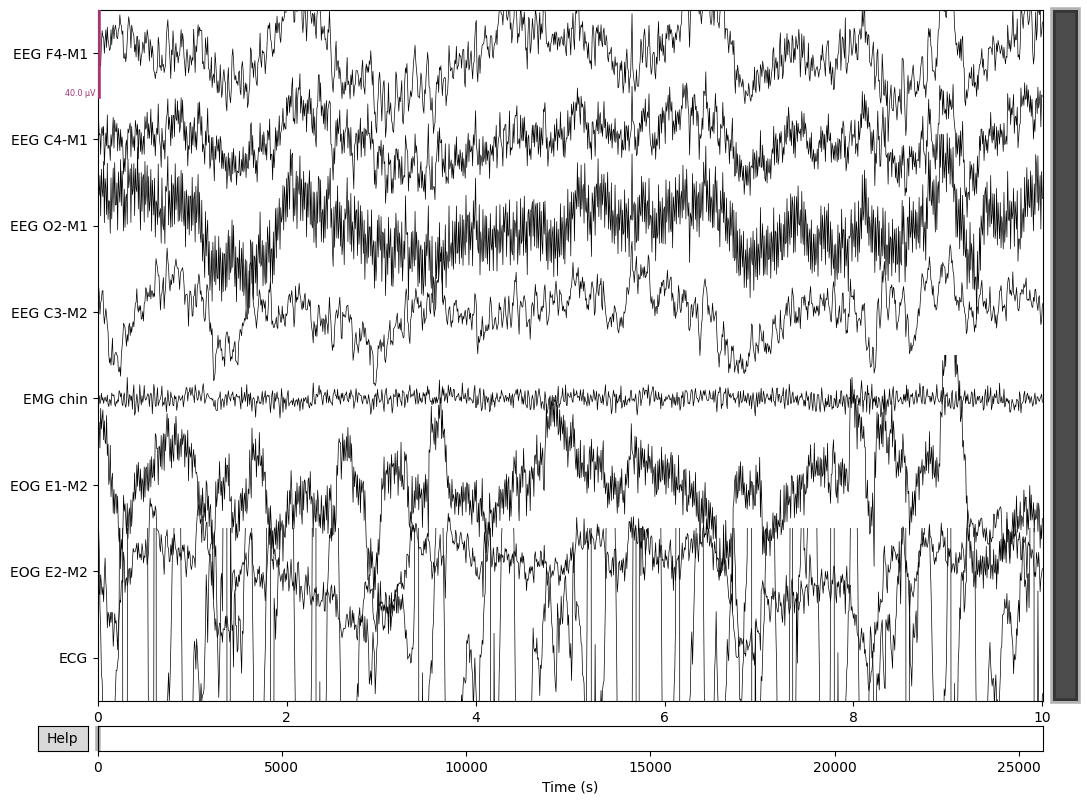

<RawEDF | SN001.edf, 8 x 6489600 (25350.0 s), ~396.1 MB, data loaded>

In [5]:
raw.plot(title='Signals');
total_duration = raw.times[-1] 
#print(raw.times, total_duration) # Get the total duration of the signal
raw.crop(tmin=150, tmax=total_duration - 150)

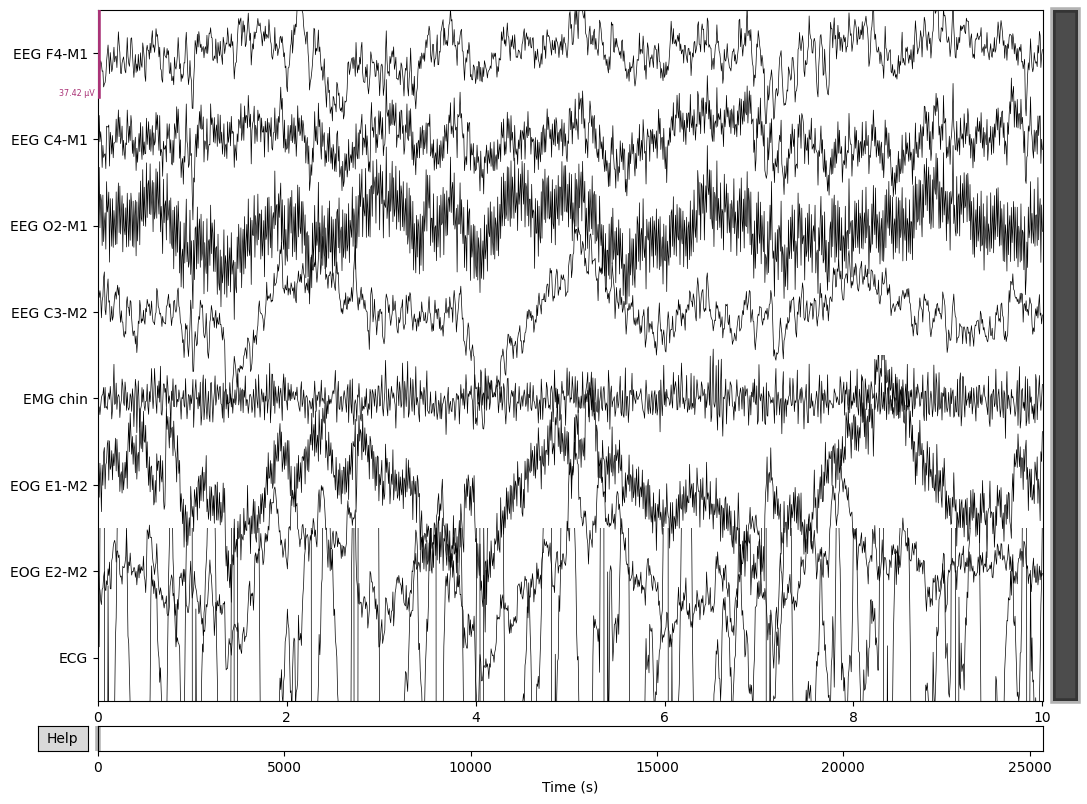

In [6]:
raw.plot(scalings='auto', title='EEG Data (After Cropping 150s)', show=True);

<RawEDF | SN001.edf, 1 x 6489600 (25350.0 s), ~49.5 MB, data loaded>


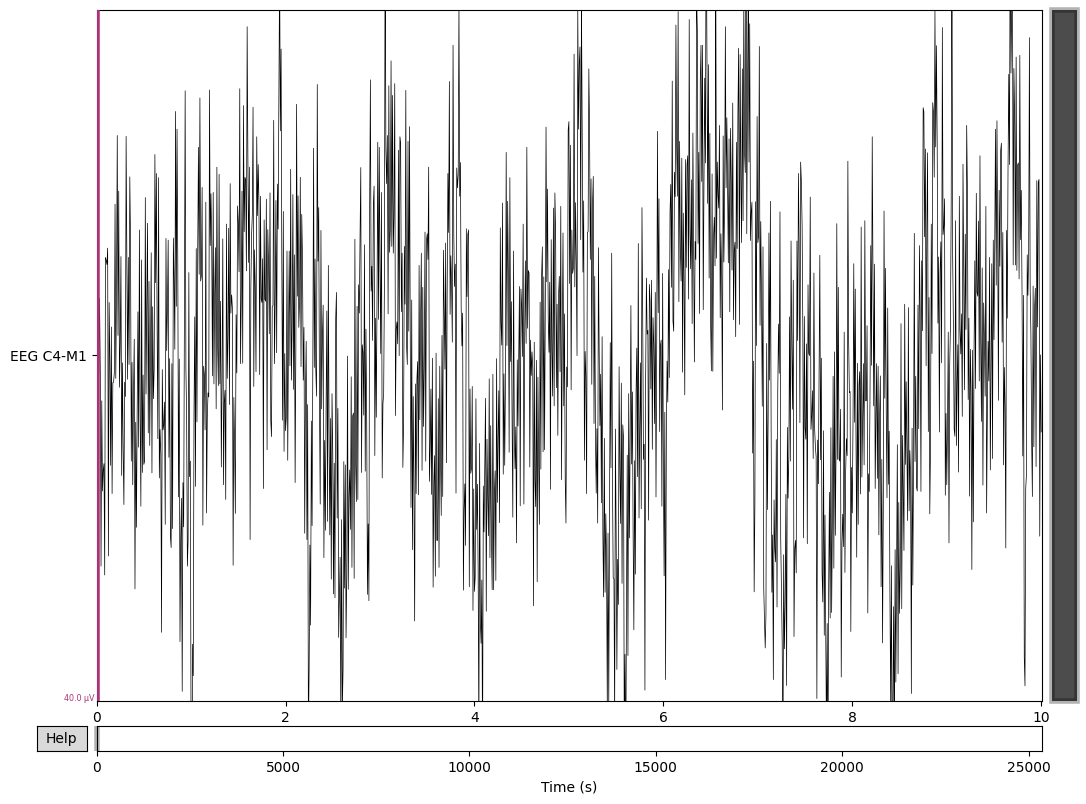

In [7]:
eeg_m1 = raw.copy().pick(['EEG C4-M1'])
print(eeg_m1)
eeg_m1.plot(title='EEG C4-M1');


In [8]:
eeg_m1.filter(0.5, 30, fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



<RawEDF | SN001.edf, 1 x 6489600 (25350.0 s), ~49.5 MB, data loaded>

In [10]:
eeg_m1.resample(100)

<RawEDF | SN001.edf, 1 x 2535000 (25350.0 s), ~19.3 MB, data loaded>

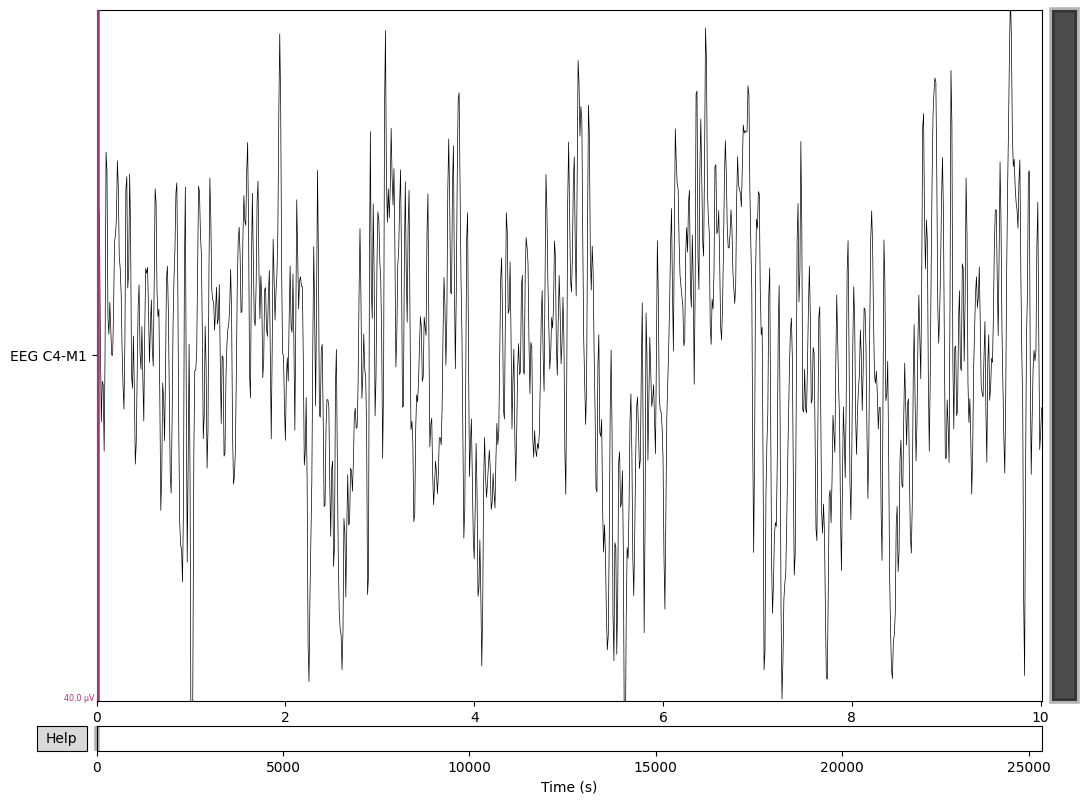

In [11]:
eeg_m1.plot(title='EEG C4-M1');


In [15]:
!pip install PyWavelets



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
# import pywt

# # Define the wavelet transform function
# def compute_wavelet_features(data, wavelet='db4', level=4):
#     coeffs = pywt.wavedec(data, wavelet, level=level)
#     # Extract statistics from each wavelet level (mean, std deviation)
#     features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
#     return features

# # Apply wavelet transform on each epoch and extract features
# wavelet_features = []
# for epoch in eeg_m1:
#     epoch_data = epoch[0].ravel()  # Flatten the data for each epoch
#     features = compute_wavelet_features(epoch_data)
#     wavelet_features.append(features)

# wavelet_features = np.array(wavelet_features)  # Convert to NumPy array for ML


In [20]:
! pip install pandas
import pandas as pd

# Load annotations
annotations_df = pd.read_csv(r'C:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001_sleepscoring.txt')  # Replace with the path to your file
annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]

# Convert onset and duration to numeric values (in seconds) if needed
annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

# Check the data
print(annotations_df.head())


  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


       Date           Time  Recording onset  Duration      Annotation  \
0  01.01.01       23.59.30             0.00        30   Sleep stage W   
1  02.01.01       00.00.00            30.00        30   Sleep stage W   
2  02.01.01   00.00.03.430            33.43         0      Lights off   
3  02.01.01       00.00.30            60.00        30   Sleep stage W   
4  02.01.01       00.01.00            90.00        30   Sleep stage W   

  Linked channel  
0                 
1                 
2      EEG F4-A1  
3                 
4                 


In [21]:
# Total duration of the recording after cropping
total_duration = raw.times[-1] - 150 * 2  # After removing 150 seconds from start and end

# Filter annotations to fit within the cropped data range
filtered_annotations_df = annotations_df[
    (annotations_df['Recording onset'] >= 150) &
    (annotations_df['Recording onset'] <= total_duration)
].copy()

# Adjust onset to account for cropping the initial 150 seconds
filtered_annotations_df['Recording onset'] -= 150

print(filtered_annotations_df.head())


        Date       Time  Recording onset  Duration       Annotation  \
6   02.01.01   00.02.00              0.0        30    Sleep stage W   
7   02.01.01   00.02.30             30.0        30    Sleep stage W   
8   02.01.01   00.03.00             60.0        30    Sleep stage W   
9   02.01.01   00.03.30             90.0        30   Sleep stage N1   
10  02.01.01   00.04.00            120.0        30   Sleep stage N1   

   Linked channel  
6                  
7                  
8                  
9                  
10                 


In [22]:
# Convert to MNE annotations
annotations = mne.Annotations(
    onset=filtered_annotations_df['Recording onset'].values,
    duration=filtered_annotations_df['Duration'].values,
    description=filtered_annotations_df['Annotation'].values
)

# Set the annotations to the raw object
raw.set_annotations(annotations)


<RawEDF | SN001.edf, 8 x 2535000 (25350.0 s), ~154.7 MB, data loaded>

In [23]:
# Bandpass filter and resample
raw.filter(0.5, 30, fir_design='firwin')
raw.resample(100)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 s)

Sampling frequency of the instance is already 100.0, returning unmodified.


<RawEDF | SN001.edf, 8 x 2535000 (25350.0 s), ~154.7 MB, data loaded>

In [24]:
# Create events from annotations
events, event_id = mne.events_from_annotations(raw)

# Epoch the data based on events
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=30, baseline=None, preload=True)

# Encode the labels for machine learning
labels = epochs.events[:, -1]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped


In [33]:
import numpy as np
import pywt

# Define the wavelet transform function
def compute_wavelet_features(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Extract statistics from each wavelet level (mean, std deviation)
    features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    return features

# Get the EEG data from the epochs object
eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)

# Apply wavelet transform on each epoch and extract features
wavelet_features = []

for epoch in eeg_data:
    # Flatten the data for each channel and extract features
    for channel_data in epoch:  # Iterate over each channel in the epoch
        features = compute_wavelet_features(channel_data)  # Process each channel separately
        wavelet_features.append(features)

# Convert to NumPy array for ML
wavelet_features = np.array(wavelet_features)


In [34]:
print(wavelet_features)

[[ 1.14077650e-06 -7.90912374e-08 -4.79676652e-08 ...  8.19710252e-06
   5.53336196e-06  2.35708097e-06]
 [ 5.25917658e-07 -8.62667035e-07  1.00046061e-07 ...  8.69121281e-06
   5.34874251e-06  2.30682590e-06]
 [ 9.11884166e-07  1.35659542e-07 -1.36986935e-07 ...  7.52637802e-06
   5.19321162e-06  2.07020021e-06]
 ...
 [-1.71271553e-07  1.99774218e-07  2.71883078e-08 ...  8.69030029e-06
   3.80359717e-06  1.28570088e-06]
 [-4.60248154e-07 -1.75929298e-07  4.03644869e-07 ...  5.64768797e-06
   2.99696663e-06  1.08851670e-06]
 [ 1.39169699e-05  1.31378545e-05  8.31420758e-06 ...  1.73811049e-04
   1.39935983e-04  4.82599079e-05]]


In [36]:
# Reshape wavelet features if needed
n_epochs = eeg_data.shape[0]  # Number of epochs
n_channels = eeg_data.shape[1]  # Number of channels
n_features_per_channel = len(wavelet_features[0])  # Number of wavelet features per channel

# Reshape to (n_epochs, n_channels * n_features_per_channel)
wavelet_features = wavelet_features.reshape(n_epochs, n_channels * n_features_per_channel)
print("Reshaped wavelet features:", wavelet_features.shape)


Reshaped wavelet features: (830, 80)


In [37]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(wavelet_features, labels, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (664, 80)
Test set shape: (166, 80)


In [38]:
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [39]:
# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8554216867469879
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55        21
           1       0.86      0.95      0.91        85
           2       0.00      0.00      0.00         5
           3       0.85      0.92      0.88        25
           4       0.88      0.97      0.92        30

    accuracy                           0.86       166
   macro avg       0.67      0.65      0.65       166
weighted avg       0.82      0.86      0.83       166



c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

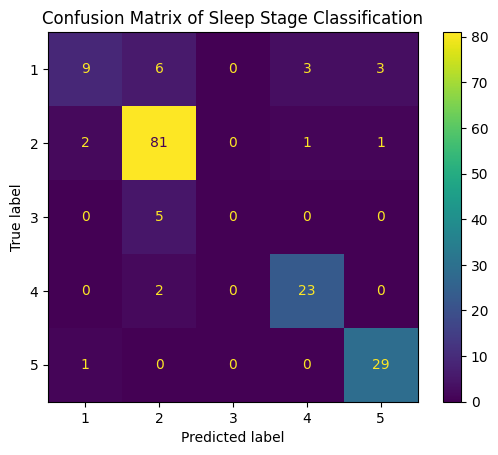

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()


In [41]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(clf, wavelet_features, labels, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


Cross-Validation Scores: [0.78915663 0.77710843 0.75903614 0.80120482 0.71686747]
Average CV Score: 0.7686746987951807


In [49]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a simple neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(wavelet_features.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # One output per sleep stage
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4245 - loss: 1.5946 - val_accuracy: 0.5338 - val_loss: 1.5266
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4901 - loss: 1.5138 - val_accuracy: 0.5338 - val_loss: 1.4034
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5152 - loss: 1.4059 - val_accuracy: 0.5338 - val_loss: 1.2984
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5043 - loss: 1.3443 - val_accuracy: 0.5338 - val_loss: 1.2711
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5155 - loss: 1.3323 - val_accuracy: 0.5338 - val_loss: 1.2666
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4665 - loss: 1.3807 - val_accuracy: 0.5338 - val_loss: 1.2672
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4888 - loss: 1.3396 - val_accuracy: 0.5338 - val_loss: 1.2603
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4879 - loss: 1.3619 - val_accuracy: 0.5338 - 